<a href="https://www.kaggle.com/code/hajer8/tomato-leaf-disease-sic?scriptVersionId=204559513" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [11]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D , Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import normalize
from tensorflow.keras.optimizers import Adam
from keras.applications.densenet import preprocess_input
from imblearn.over_sampling import RandomOverSampler


  
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121


from sklearn.metrics import classification_report, confusion_matrix





# Data

In [2]:
# train data
labels = ['Late_blight','healthy','Early_blight','Septoria_leaf_spot','Tomato_Yellow_Leaf_Curl_Virus','Bacterial_spot','Target_Spot','Tomato_mosaic_virus','Leaf_Mold','Spider_mites Two-spotted_spider_mite','powdery_mildew']

train_path = r'/kaggle/input/tomato-disease-multiple-sources/train'
train_data = []
for i in labels:
    label_path_train = os.path.join(train_path , i)
    clas = labels.index(i)
    
    for img in os.listdir(label_path_train):
        new_img = cv2.imread(os.path.join(label_path_train, img))
        new_img = cv2.resize(new_img, (256,256))
        train_data.append([new_img , clas])
        

In [3]:
# split to features & label 

random.shuffle(train_data)    
x_train =[]
y_train = []
for feature ,label in train_data:
  x_train.append(feature)
  y_train.append(label)  
x_train = np.array(x_train)
y_train = np.array(y_train)

In [5]:
# test data
test_path = r'/kaggle/input/tomato-disease-multiple-sources/valid'
test_data = []
not_img = []
for i in labels:
    label_path_test = os.path.join(test_path , i)
    clas = labels.index(i)
    
    for img in os.listdir(label_path_test):
        try:
           new_img = cv2.imread(os.path.join(label_path_test, img))
           new_img = cv2.resize(new_img , (256,256))
           test_data.append([new_img , clas])
            
        except:
            not_img.append(img)
            print('photo not found')

libpng error: Read Error


photo not found


In [6]:
# split to features & label 

random.shuffle(test_data)    
x_test =[]
y_test = []
for feature ,label in test_data:
  x_test.append(feature)
  y_test.append(label)  
x_test = np.array(x_test)
y_test = np.array(y_test)

# EDA

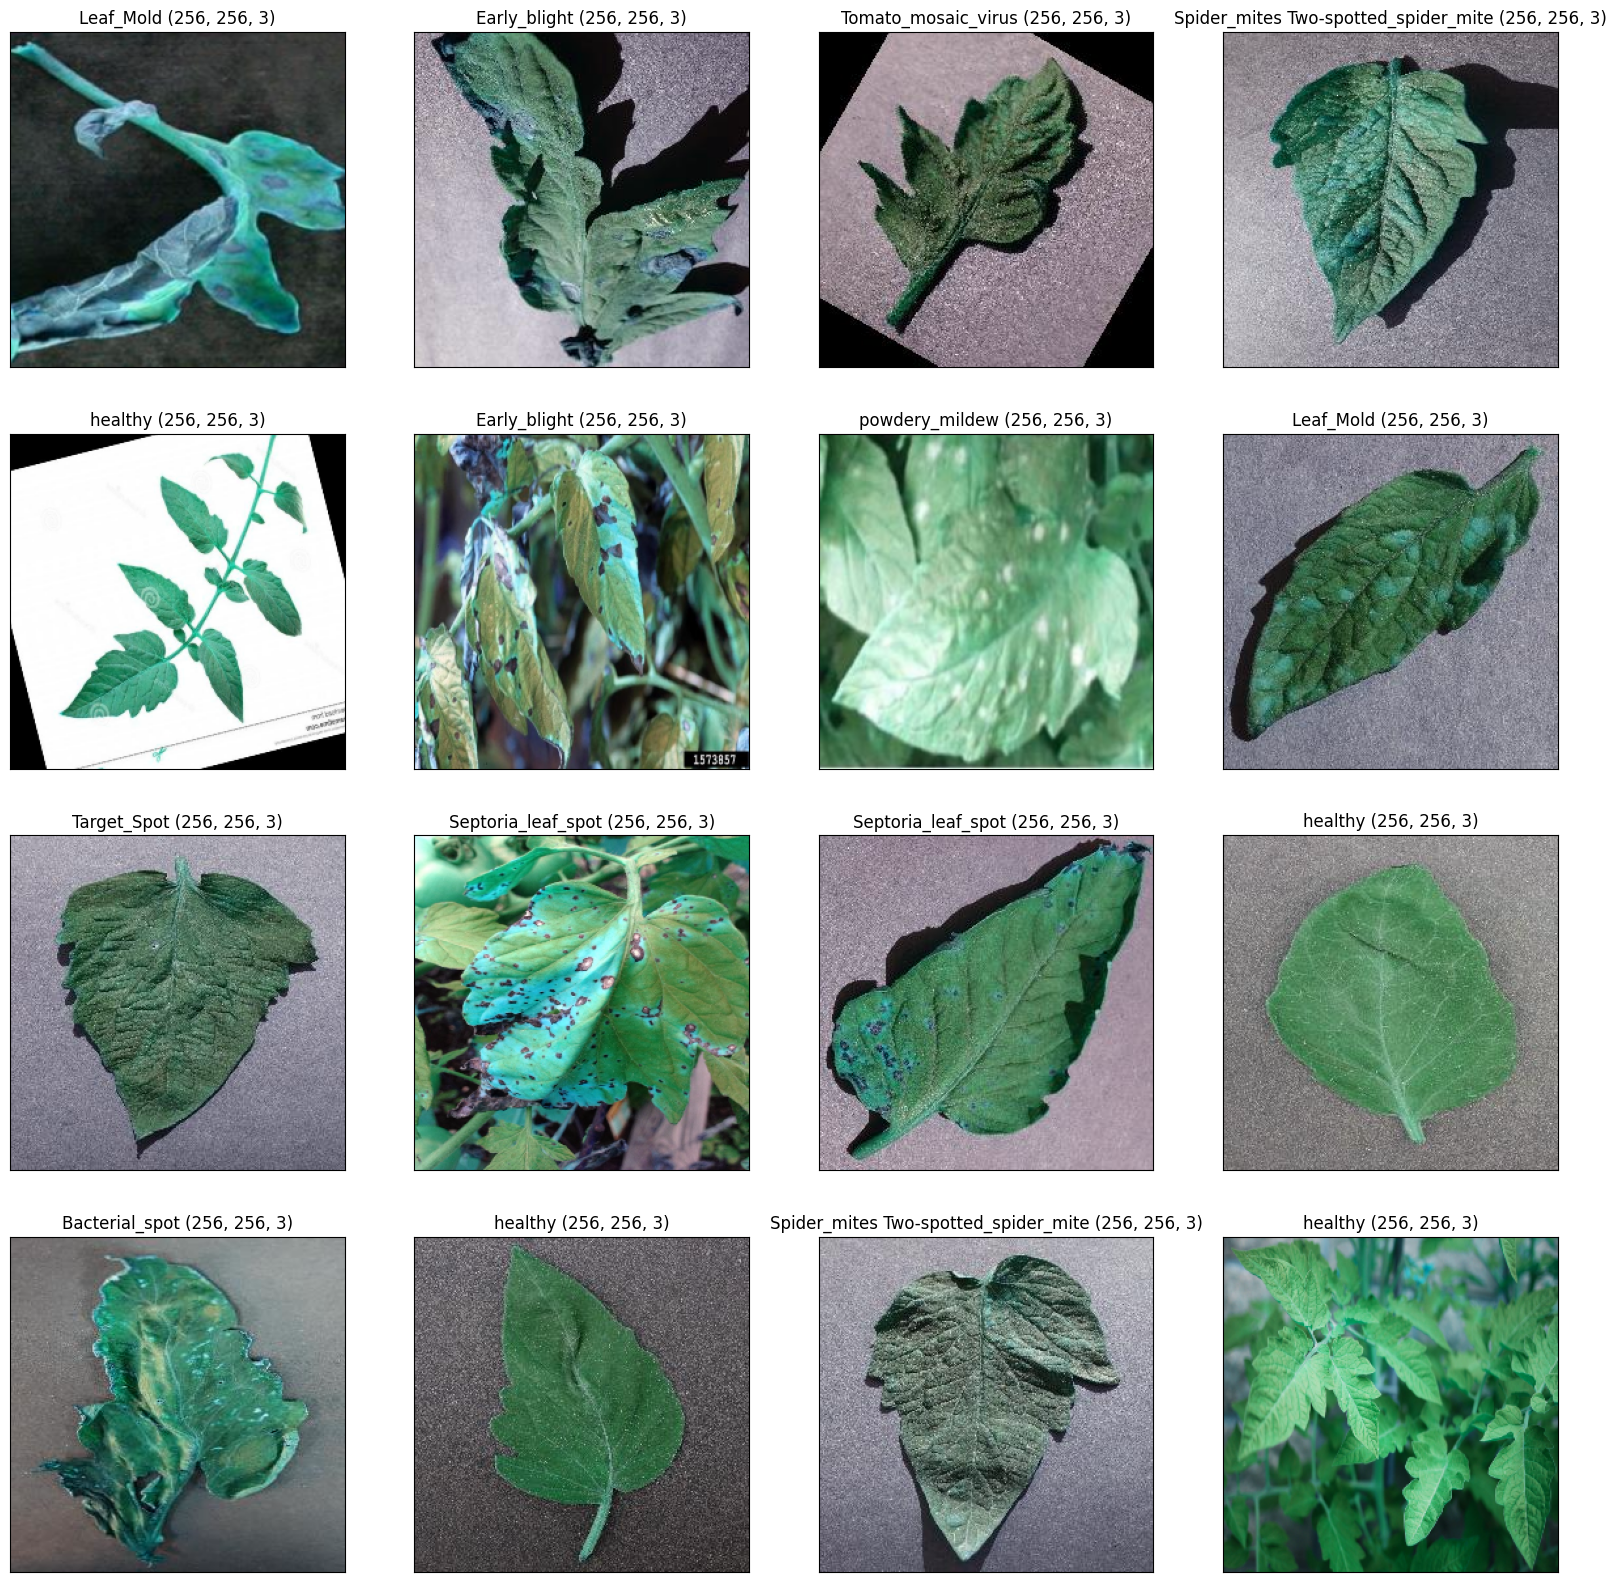

In [7]:
# show sample from data
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_data[i][0])
    plt.title(f"{labels[y_train[i]]} {train_data[i][0].shape}")
    plt.xticks([])
    plt.yticks([])
    
    
plt.show()

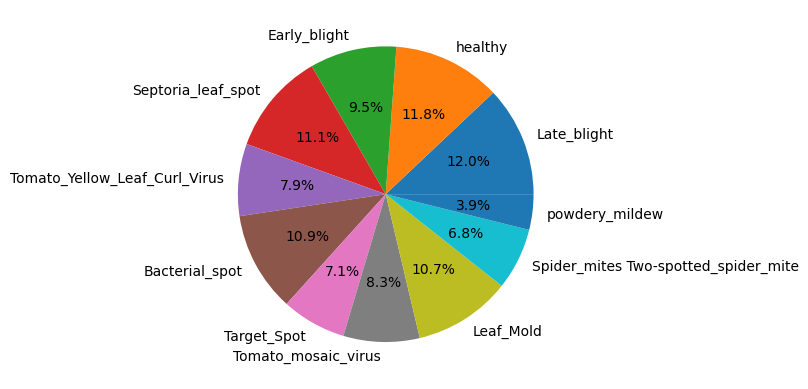

In [8]:
# pie
plt.pie([(len(y_train[y_train == 0])) , (len(y_train[y_train == 1])) ,(len(y_train[y_train == 2])),(len(y_train[y_train == 3])),(len(y_train[y_train == 4])),(len(y_train[y_train == 5])),(len(y_train[y_train == 6])),(len(y_train[y_train == 7])),(len(y_train[y_train == 8])),(len(y_train[y_train == 9])),(len(y_train[y_train == 10]))],labels = labels , autopct="%1.1f%%",
                                       )
plt.show()

In [9]:
print(len(y_train))
print(len(y_test))

25851
6683


# Handle Unbalancing

In [13]:
num_samples, height, width, channels = x_train.shape
x_train_flat = x_train.reshape(num_samples, height * width * channels)

# Apply RandomOverSampler
ovrs = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ovrs.fit_resample(x_train_flat, y_train)

# Optionally, reshape data_resampled back to original image shape
data_resampled = data_resampled.reshape(-1, height, width, channels)

print(data_resampled.shape)
print(labels_resampled.shape)

(34243, 256, 256, 3)
(34243,)


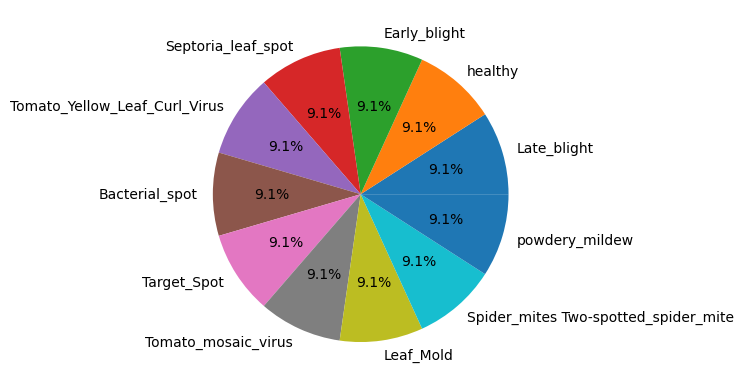

In [14]:
# pie
plt.pie([(len(labels_resampled[labels_resampled == 0])) , (len(labels_resampled[labels_resampled == 1])) ,(len(labels_resampled[labels_resampled == 2])),(len(labels_resampled[labels_resampled == 3])),(len(labels_resampled[labels_resampled == 4])),(len(labels_resampled[labels_resampled == 5])),(len(labels_resampled[labels_resampled == 6])),(len(labels_resampled[labels_resampled == 7])),(len(labels_resampled[labels_resampled == 8])),(len(labels_resampled[labels_resampled == 9])),(len(labels_resampled[labels_resampled == 10]))],labels = labels , autopct="%1.1f%%",
                                       )
plt.show()

# Data augmantaion

In [15]:
train_generator = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,  
    vertical_flip=True,
     validation_split=0.2,
    preprocessing_function=preprocess_input
    
)


In [16]:
train_data = train_generator.flow_from_directory(
    '/kaggle/input/tomato-disease-multiple-sources/train',
    target_size=(256, 256),
    batch_size=120,
    class_mode='categorical',
    subset='training',  # Set as training data
    seed=42 , # For reproducibility
    shuffle = True
)

Found 20686 images belonging to 11 classes.


In [17]:
val_data = train_generator.flow_from_directory(
    '/kaggle/input/tomato-disease-multiple-sources/train',
    target_size=(256, 256),
    batch_size=120,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    seed=42  # For reproducibility
)

Found 5165 images belonging to 11 classes.


# Transformers

In [18]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    pooling='avg'
)
for layer in base_model.layers:
    layer.trainable = False

/tmp/ipykernel_30/4088479171.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
model_2 = Sequential()
model_2.add(base_model)
model_2.add(BatchNormalization())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.35))
model_2.add(BatchNormalization())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(150, activation='relu'))
model_2.add(Dense(180, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(11, activation='softmax'))

In [20]:

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
history = model_2.fit(train_data, epochs=1,
                    validation_data= val_data
                    
                   )

173/173 ━━━━━━━━━━━━━━━━━━━━ 1273s 7s/step - accuracy: 0.5687 - loss: 1.2102 - val_accuracy: 0.8327 - val_loss: 0.5363


In [25]:
predictions = model_2.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)




209/209 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step


In [26]:
# Print classification report
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       792
           1       0.00      0.00      0.00       805
           2       0.00      0.00      0.00       643
           3       0.00      0.00      0.00       746
           4       0.00      0.00      0.00       498
           5       0.00      0.00      0.00       732
           6       0.00      0.00      0.00       457
           7       0.00      0.00      0.00       584
           8       0.03      0.00      0.00       739
           9       0.07      1.00      0.12       435
          10       0.00      0.00      0.00       252

    accuracy                           0.07      6683
   macro avg       0.01      0.09      0.01      6683
weighted avg       0.01      0.07      0.01      6683



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


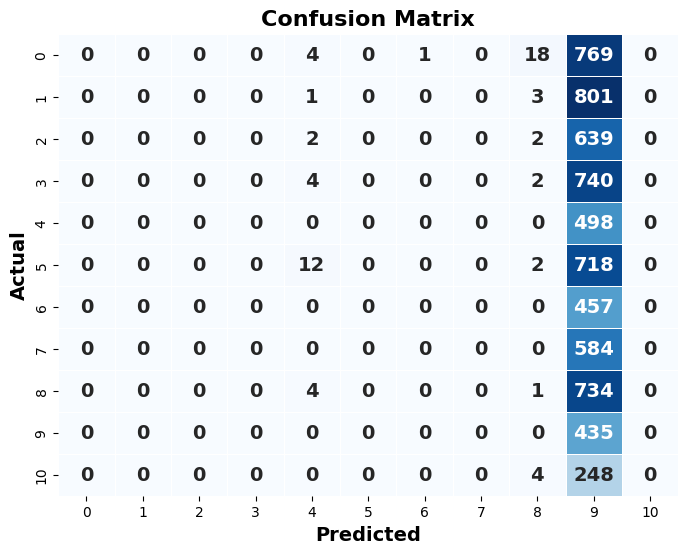

In [28]:
# confusion matrix
import seaborn as sns
confusion = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14, 'weight': 'bold'}, linewidths=.5)

# Customize labels and title
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()